In [1]:
# Auto reload settings
#%%

%load_ext autoreload
%autoreload 2
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
# Imports

import sys

from utils import compute_average_across_sequences, process_datapoint
from torch.utils.data import DataLoader
from transformers import DataCollatorForLanguageModeling
from parlai.utils.strings import colorize
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import copy
pd.options.plotting.backend = "matplotlib"



In [3]:
# beautify graphs.

sns.set_style('whitegrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('font', size=11)          # controls default text sizes

palatte=sns.color_palette('pastel')
palatte

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

In [4]:
# Plot mean and std average entropy

def plot_avg_entropies_mean_std(entropies, label=None, ax=None,  color='red', linewidth=1, std_dev=1.5):
    entropy_mean = np.ma.mean(entropies, axis=0)
    entropy_std = np.ma.std(entropies, axis=0)
    ax = sns.lineplot(y=entropy_mean, x=np.arange(len(entropy_mean)), 
                    ax=ax, label=label, color=color, linewidth=linewidth)
    # sns.lineplot(entropy_mean, ax=ax, label=label)

    ax.set_ylim(0,6)
    ax.fill_between(range(len(entropy_mean)), entropy_mean -  std_dev * entropy_std, 
                                                entropy_mean +  std_dev * entropy_std, alpha=0.1, color=color)
    # ax=ax.set_xticks(np.arange(len(entropy_mean)), step=100)


# Stable Entropy Baselines

In [5]:
NUM_SEQ=2000
MAX_LEN=100
WIDTH=5
MAX_SOURCE_LEN=1024
STD_DEV=1.5


## Text Completion

In [6]:
# Text Completion data
wikipedia_text_completion = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/orig.jsonl"
writing_prompt_completion = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/writingPrompts/generated/orig.jsonl"
cc_news = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/cc_news/generated/orig.jsonl"
pg19_completion = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/pg19_rankgen/generated/orig.jsonl"
# Summarization

In [7]:
# GPT-2 XL Model
from transformers import AutoTokenizer, AutoModelForCausalLM
gpt2_tokenizer = AutoTokenizer.from_pretrained("gpt2-xl")
gpt2_model = AutoModelForCausalLM.from_pretrained("gpt2-xl")
gpt2_model = gpt2_model.to('cuda')

In [8]:
# Load GPT2 model fine-tuned on writing prompts

# gpt2_writing_prompt_modelfile = "/home/mila/a/arorakus/scratch/ews/finetuned_writing_prompts/08-14-2022-11-03/checkpoint-71000/"
gpt2_writing_prompt_modelfile = "/home/mila/a/arorakus/scratch/ews/finetuned_writing_prompts/08-18-2022-05-33-01/checkpoint-55000/"
# gpt2_writing_prompt_modelfile = 'gpt2-large'
model_args = ModelArguments(
    model_name_or_path=gpt2_writing_prompt_modelfile,   
)
fine_tuned_gpt2_model = get_model(model_args)
fine_tuned_gpt2_model.to('cuda')
fine_tuned_tokenizer = get_tokenizer(model_args)
fine_tuned_tokenizer.pad_token = fine_tuned_tokenizer.eos_token
fine_tuned_gpt2_model = gpt2_model.to('cuda')

# compute_metrics = get_compute_metrics_func(experiment_id="jupyter_ipynb", metric_names=['accuracy', 'mauve'])

In [9]:
wikipedia_dataframe = pd.read_json(wikipedia_text_completion, lines=True)
writing_prompt_dataframe = pd.read_json(writing_prompt_completion, lines=True)
cc_news_dataframe = pd.read_json(cc_news, lines=True)
pg19_dataframe = pd.read_json(pg19_completion, lines=True)

Loading from:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/15225bf23edd251597a8e6875a351601-dac29fcb1d58e463f4e58bb261c1f9a2-human_generated-100-2000-entropy_ma-5-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/15225bf23edd251597a8e6875a351601-dac29fcb1d58e463f4e58bb261c1f9a2-human_generated-100-2000-entropy_ma-5-avgs.csv


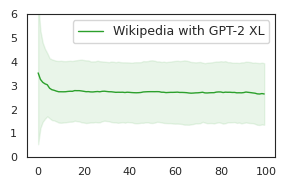

In [10]:
sns.set_style('white') # darkgrid, white grid, dark, white and ticks
# Wikipedia and GPT-2 XL
dataframe, dataset_name = (wikipedia_dataframe, "Wikipedia")
model,tokenizer,model_name = (gpt2_model, gpt2_tokenizer, "GPT-2 XL")
_, wiki_gpt2_xl_ma_entropies = compute_average_across_sequences(dataframe, model, tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True)

fig, ax = plt.subplots(figsize=(3,2), tight_layout=True)
plot_avg_entropies_mean_std(wiki_gpt2_xl_ma_entropies, 
    label=f"{dataset_name} with {model_name}", ax=ax, 
    color='tab:green', linewidth=1.0)
ax.legend(fontsize=9, loc="upper right",)
ax.tick_params(labelsize=8)


Loading from:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/b302ba8db7af6a40de816c5305dbc041-dac29fcb1d58e463f4e58bb261c1f9a2-human_generated-100-2000-entropy_ma-5-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/b302ba8db7af6a40de816c5305dbc041-dac29fcb1d58e463f4e58bb261c1f9a2-human_generated-100-2000-entropy_ma-5-avgs.csv


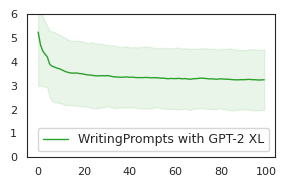

In [11]:
# Writing Prompts and GPT-2 XL
dataframe, dataset_name = (writing_prompt_dataframe, "WritingPrompts")
model,tokenizer,model_name = (gpt2_model, gpt2_tokenizer, "GPT-2 XL")
_, writing_prompts_gpt2_ma_entropies = compute_average_across_sequences(dataframe, model, tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True)

fig, ax = plt.subplots(figsize=(3,2), tight_layout=True)
plot_avg_entropies_mean_std(writing_prompts_gpt2_ma_entropies, 
    label=f"{dataset_name} with {model_name}", ax=ax, 
    color='tab:green', linewidth=1.0)
ax.legend(fontsize=9, loc="lower right")
ax.tick_params(labelsize=8)


Loading from:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/cc147bcc3b41e2a6d08ce60d402b4081-dac29fcb1d58e463f4e58bb261c1f9a2-human_generated-100-2000-entropy_ma-5-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/cc147bcc3b41e2a6d08ce60d402b4081-dac29fcb1d58e463f4e58bb261c1f9a2-human_generated-100-2000-entropy_ma-5-avgs.csv


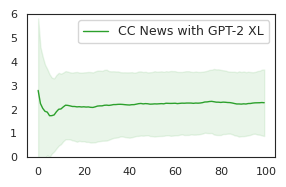

In [12]:
# CC News and GPT-2 XL
dataframe, dataset_name = (cc_news_dataframe, "CC News")
model,tokenizer,model_name = (gpt2_model, gpt2_tokenizer, "GPT-2 XL")
_, cc_gpt2_xl_ma_entropies = compute_average_across_sequences(dataframe, model, tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True)

fig, ax = plt.subplots(figsize=(3,2), tight_layout=True)
plot_avg_entropies_mean_std(cc_gpt2_xl_ma_entropies, 
    label=f"{dataset_name} with {model_name}", ax=ax, 
    color='tab:green', linewidth=1.0)
ax.legend(fontsize=9, loc="upper right")
ax.tick_params(labelsize=8)

Loading from:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/d9eb677437174a28f3d6d3ec914390b2-dac29fcb1d58e463f4e58bb261c1f9a2-human_generated-100-2000-entropy_ma-5-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/d9eb677437174a28f3d6d3ec914390b2-dac29fcb1d58e463f4e58bb261c1f9a2-human_generated-100-2000-entropy_ma-5-avgs.csv


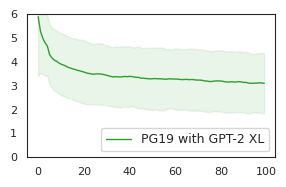

In [13]:
# PG19 and GPT-2 XL
dataframe, dataset_name = (pg19_dataframe, "PG19")
model,tokenizer,model_name = (gpt2_model, gpt2_tokenizer, "GPT-2 XL")
_, pg19_gpt2_xl_ma_entropies = compute_average_across_sequences(dataframe, model, tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True)

fig, ax = plt.subplots(figsize=(3,2), tight_layout=True)
plot_avg_entropies_mean_std(pg19_gpt2_xl_ma_entropies, 
    label=f"{dataset_name} with {model_name}", ax=ax, 
    color='tab:green', linewidth=1.0)
ax.legend(fontsize=9, loc="lower right")
ax.tick_params(labelsize=8)

In [14]:
from transformers import AutoTokenizer, AutoModelForCausalLM
opt_tokenizer = AutoTokenizer.from_pretrained("facebook/opt-1.3b")
opt_model = AutoModelForCausalLM.from_pretrained("facebook/opt-1.3b")
opt_model = opt_model.to("cuda")

Loading from:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/15225bf23edd251597a8e6875a351601-4af75f5d09b0bc8e1071d7f02b79cb0c-human_generated-100-2000-entropy_ma-5-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/15225bf23edd251597a8e6875a351601-4af75f5d09b0bc8e1071d7f02b79cb0c-human_generated-100-2000-entropy_ma-5-avgs.csv


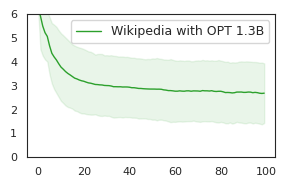

In [15]:
# Wikipedia and OPT
dataframe, dataset_name = (wikipedia_dataframe, "Wikipedia")
model, tokenizer, model_name = (opt_model, opt_tokenizer, "OPT 1.3B")
_, wiki_opt_ma_entropies = compute_average_across_sequences(dataframe, model, tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True)

fig, ax = plt.subplots(figsize=(3,2), tight_layout=True)
plot_avg_entropies_mean_std(wiki_opt_ma_entropies, 
    label=f"{dataset_name} with {model_name}", ax=ax, 
    color='tab:green', linewidth=1.0)
ax.legend(fontsize=9, loc="upper right",)
ax.tick_params(labelsize=8)

Loading from:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/b302ba8db7af6a40de816c5305dbc041-4af75f5d09b0bc8e1071d7f02b79cb0c-human_generated-100-2000-entropy_ma-5-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/b302ba8db7af6a40de816c5305dbc041-4af75f5d09b0bc8e1071d7f02b79cb0c-human_generated-100-2000-entropy_ma-5-avgs.csv


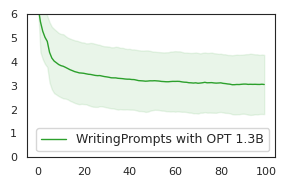

In [16]:
# Writing Prompts and OPT
dataframe, dataset_name = (writing_prompt_dataframe, "WritingPrompts")
model, tokenizer, model_name = (opt_model, opt_tokenizer, "OPT 1.3B")
_, wp_opt_ma_entropies = compute_average_across_sequences(dataframe, model, tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True)

fig, ax = plt.subplots(figsize=(3,2), tight_layout=True)
plot_avg_entropies_mean_std(wp_opt_ma_entropies, 
    label=f"{dataset_name} with {model_name}", ax=ax, 
    color='tab:green', linewidth=1.0)
ax.legend(fontsize=9, loc="lower right")
ax.tick_params(labelsize=8)


Loading from:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/cc147bcc3b41e2a6d08ce60d402b4081-4af75f5d09b0bc8e1071d7f02b79cb0c-human_generated-100-2000-entropy_ma-5-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/cc147bcc3b41e2a6d08ce60d402b4081-4af75f5d09b0bc8e1071d7f02b79cb0c-human_generated-100-2000-entropy_ma-5-avgs.csv


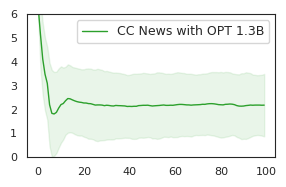

In [17]:
# CC News and OPT
dataframe, dataset_name = (cc_news_dataframe, "CC News")
model, tokenizer, model_name = (opt_model, opt_tokenizer, "OPT 1.3B")
_, cc_opt_ma_entropies = compute_average_across_sequences(dataframe, model, tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True)

fig, ax = plt.subplots(figsize=(3,2), tight_layout=True)
plot_avg_entropies_mean_std(cc_opt_ma_entropies, 
    label=f"{dataset_name} with {model_name}", ax=ax, 
    color='tab:green', linewidth=1.0)
ax.legend(fontsize=9,loc="upper right")
ax.tick_params(labelsize=8)

Loading from:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/d9eb677437174a28f3d6d3ec914390b2-4af75f5d09b0bc8e1071d7f02b79cb0c-human_generated-100-2000-entropy_ma-5-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/d9eb677437174a28f3d6d3ec914390b2-4af75f5d09b0bc8e1071d7f02b79cb0c-human_generated-100-2000-entropy_ma-5-avgs.csv


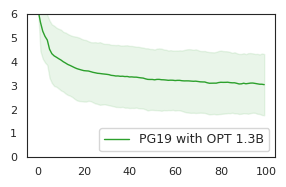

In [18]:
# PG19 and GPT-2 XL
dataframe, dataset_name = (pg19_dataframe, "PG19")
model,tokenizer,model_name = (opt_model, opt_tokenizer, "OPT 1.3B")
_, pg19_gpt_ma_entropies = compute_average_across_sequences(dataframe, model, tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True)

fig, ax = plt.subplots(figsize=(3,2), tight_layout=True)
plot_avg_entropies_mean_std(pg19_gpt_ma_entropies, 
    label=f"{dataset_name} with {model_name}", ax=ax, 
    color='tab:green', linewidth=1.0)
ax.legend(fontsize=9, loc="lower right")
ax.tick_params(labelsize=8)

## Summarization

In [19]:
# Load Pegasus fine-tuned on cnn_dailymail
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

pegasusxl_model = AutoModelForSeq2SeqLM.from_pretrained("google/pegasus-cnn_dailymail")

pegasusxl_model = pegasusxl_model.to('cuda')
pegasusxl_tokenizer = AutoTokenizer.from_pretrained("google/pegasus-cnn_dailymail")


In [20]:
cnn_dm_data='/home/mila/a/arorakus/wdir/entropy_aware_search/data/cnn_dm_pegasus/generated/orig.jsonl'
cnn_dm_dataframe = pd.read_json(cnn_dm_data, lines=True)\
                        .rename(columns={'document':'context', 
                                         'summary': 'model_text'})

In [21]:
_, cnn_pegasus_entropies = compute_average_across_sequences(cnn_dm_dataframe, pegasusxl_model, pegasusxl_tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN)

Loading from:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/65435bd7eabc56bf4143ddbd46654176-4a5985cbc3ce861a1fbc1d173cd0f018-human_generated-100-2000-entropy_ma-5-1024-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/65435bd7eabc56bf4143ddbd46654176-4a5985cbc3ce861a1fbc1d173cd0f018-human_generated-100-2000-entropy_ma-5-1024-avgs.csv


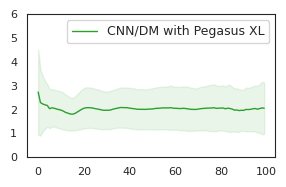

In [22]:
# CNN/DM and PegasusXL
dataset_name = "CNN/DM"
model_name = "Pegasus XL"
fig, ax = plt.subplots(figsize=(3,2), tight_layout=True)
plot_avg_entropies_mean_std(cnn_pegasus_entropies, 
    label=f"{dataset_name} with {model_name}", ax=ax, 
    color='tab:green', linewidth=1.0)
ax.legend(fontsize=9, loc="upper right")
ax.tick_params(labelsize=8)

In [23]:
## BART

In [24]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

bart_tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")

bart_model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")
bart_model = bart_model.to("cuda")

In [25]:
_, cnn_bart_entropies = compute_average_across_sequences(cnn_dm_dataframe, bart_model, bart_tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN)

Loading from:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/65435bd7eabc56bf4143ddbd46654176-5b42467931ab343e502e9a74e5e22ed3-human_generated-100-2000-entropy_ma-5-1024-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/65435bd7eabc56bf4143ddbd46654176-5b42467931ab343e502e9a74e5e22ed3-human_generated-100-2000-entropy_ma-5-1024-avgs.csv


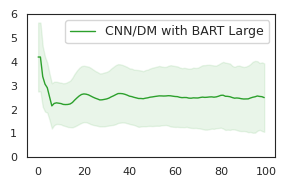

In [27]:
# CNN/DM and BART
dataset_name = "CNN/DM"
model_name = "BART Large"
fig, ax = plt.subplots(figsize=(3,2), tight_layout=True)
plot_avg_entropies_mean_std(cnn_bart_entropies, 
    label=f"{dataset_name} with {model_name}", ax=ax, 
    color='tab:green', linewidth=1.0)
ax.legend(fontsize=9, loc="upper right")
ax.tick_params(labelsize=8)

## Dialog

In [28]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

bb_tokenizer = AutoTokenizer.from_pretrained("facebook/blenderbot-1B-distill")

bb_model = AutoModelForSeq2SeqLM.from_pretrained("facebook/blenderbot-1B-distill")
bb_model = bb_model.to("cuda")

In [29]:
bst_data='/home/mila/a/arorakus/wdir/entropy_aware_search/data/blended_skill_talk/generated/orig.jsonl'
bst_dataframe = pd.read_json(bst_data, lines=True)
MAX_SOURCE_LEN=128
MAX_LEN=40
NUM_SEQ=10000

In [30]:
bsts, bst_entropies = compute_average_across_sequences(bst_dataframe, bb_model, bb_tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True, is_seq2seq=True, max_source_len=MAX_SOURCE_LEN)

Loading from:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/ce05ac029117df81e3870e0d18b76ac9-c565657fbe27b7aaf47dcc290dd54faf-human_generated-40-10000-entropy_ma-5-128-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/ce05ac029117df81e3870e0d18b76ac9-c565657fbe27b7aaf47dcc290dd54faf-human_generated-40-10000-entropy_ma-5-128-avgs.csv


In [31]:
import numpy as np
arr=np.load('/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/2f6d20a0018f307bac43472b608139b0-eb7a18a7c936b032102d589950efd6c2-human_generated-60-5000-entropy_ma-5-128-ndarray.npy')

In [32]:
counts, bins = np.histogram(np.sort((arr > -1).sum(axis=1)), bins=20)

In [33]:
[(x,y) for x,y in zip(counts.tolist(), bins.tolist())]

[(203, 12.0),
 (471, 14.2),
 (588, 16.4),
 (608, 18.6),
 (582, 20.8),
 (739, 23.0),
 (432, 25.200000000000003),
 (351, 27.400000000000002),
 (284, 29.6),
 (270, 31.8),
 (264, 34.0),
 (103, 36.2),
 (56, 38.400000000000006),
 (21, 40.6),
 (12, 42.800000000000004),
 (11, 45.0),
 (2, 47.2),
 (0, 49.400000000000006),
 (1, 51.6),
 (2, 53.800000000000004)]

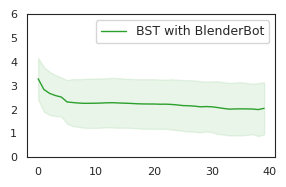

In [34]:
# Empathetic Dialog and BB1
dataset_name = "BST"
model_name = "BlenderBot"
fig, ax = plt.subplots(figsize=(3,2), tight_layout=True)
plot_avg_entropies_mean_std(bst_entropies, 
    label=f"{dataset_name} with {model_name}", ax=ax, 
    color='tab:green', linewidth=1.0)
ax.legend(fontsize=9, loc="upper right")
ax.tick_params(labelsize=8)

# Correlation Plots

Text(0.5, 0, 'Time Steps')

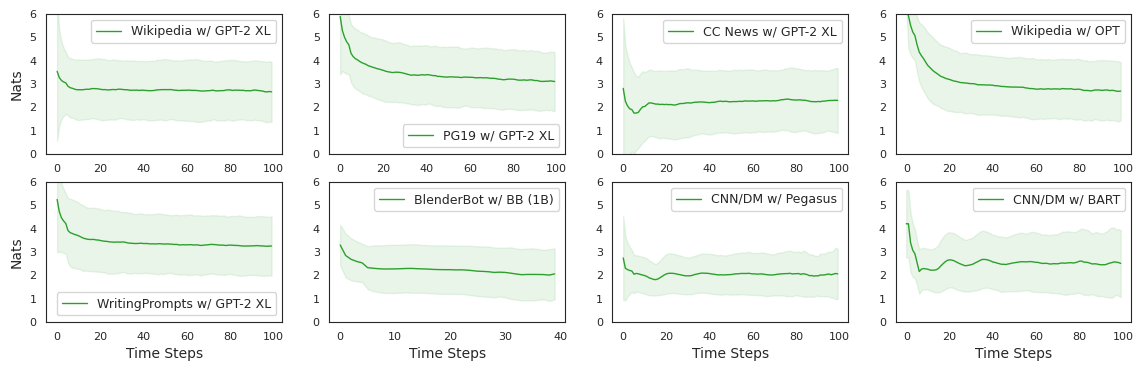

In [39]:
plt.rc('xtick', labelsize=8)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels
plt.rc('legend', fontsize=8)    # legend fontsize
plt.rc('font', size=9)          # controls default text sizes

fig, axs = plt.subplots(2,4, figsize=(14, 4))
plot_avg_entropies_mean_std(wiki_gpt2_xl_ma_entropies, ax=axs[0, 0], label=f"Wikipedia w/ GPT-2 XL", color='tab:green', std_dev=STD_DEV, linewidth=1.0)
axs[0, 0].legend(fontsize=9, loc="upper right")
axs[0, 0].tick_params(labelsize=8)
axs[0, 0].set_xlabel(None)
axs[0,0].set_ylabel("Nats", fontsize=10)

plot_avg_entropies_mean_std(pg19_gpt2_xl_ma_entropies,  ax=axs[0, 1], label=f"PG19 w/ GPT-2 XL", color='tab:green', std_dev=STD_DEV, linewidth=1.0)
axs[0, 1].legend(fontsize=9, loc="lower right")
axs[0, 1].tick_params(labelsize=8)
axs[0, 1].set_xlabel(None)

plot_avg_entropies_mean_std(cc_gpt2_xl_ma_entropies,  ax=axs[0, 2], label=f"CC News w/ GPT-2 XL", color='tab:green', std_dev=STD_DEV, linewidth=1.0)
axs[0, 2].legend(fontsize=9, loc="upper right")
axs[0, 2].tick_params(labelsize=8)
axs[0,2].set_xlabel(None)

plot_avg_entropies_mean_std(wiki_opt_ma_entropies,  ax=axs[0,3], label=f"Wikipedia w/ OPT", color='tab:green', std_dev=STD_DEV, linewidth=1.0)
axs[0,3].legend(fontsize=9, loc="upper right")
axs[0,3].tick_params(labelsize=8)
axs[0,3].set_xlabel(None)

plot_avg_entropies_mean_std(writing_prompts_gpt2_ma_entropies,  ax=axs[1,0], label=f"WritingPrompts w/ GPT-2 XL", color='tab:green', std_dev=STD_DEV, linewidth=1.0)
axs[1,0].legend(fontsize=9, loc="lower right")
axs[1,0].tick_params(labelsize=8)
axs[1,0].set_xlabel("Time Steps", fontsize=10)
axs[1,0].set_ylabel("Nats", fontsize=10)

plot_avg_entropies_mean_std(bst_entropies,  ax=axs[1,1], color='tab:green', label="BlenderBot w/ BB (1B)", std_dev=STD_DEV, linewidth=1.0)
axs[1,1].legend(fontsize=9, loc="upper right")
axs[1,1].tick_params(labelsize=8)
axs[1,1].set_xlabel("Time Steps", fontsize=10)

plot_avg_entropies_mean_std(cnn_pegasus_entropies,  ax=axs[1,2], label="CNN/DM w/ Pegasus", color='tab:green', std_dev=STD_DEV, linewidth=1.0)
axs[1,2].legend(fontsize=9, loc="upper right")
axs[1,2].tick_params(labelsize=8)
axs[1,2].set_xlabel("Time Steps", fontsize=10)

plot_avg_entropies_mean_std(cnn_bart_entropies, ax=axs[1,3], label="CNN/DM w/ BART", color='tab:green', std_dev=STD_DEV, linewidth=1.0)
axs[1,3].legend(fontsize=9, loc="upper right")
axs[1,3].tick_params(labelsize=8)
axs[1,3].set_xlabel("Time Steps", fontsize=10)

In [7]:
correlation_data = pd.read_csv('/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/corr_analysis/gpt2_xl/compiled_results.csv', index_col=0)
correlation_data['Decoding Method'] = correlation_data['dataset'].str.extract("(top_k|temp|top_p|typical|eags|beam|greedy)")
# correlation_data['Decoding Method'].str.replace("eags", "temperature")
# correlation_data['Decoding Method'].str.replace("temp", "temperature")
correlation_data

,repeat_score@5,ngram_repeat@3,f1_score,dataset,entropy_violation_ratio,num_generations,avg_compute_time_in_secs,upper_bound_violation_ratio,lower_bound_violation_ratio,mauve,Decoding Method
0,2.779710,51.286197,0.096067,data/wiki_rankgen/corr_analysis/gpt2_xl/beam_1...,0.651456,7713,0.0,0.002549,0.648907,0.146673,beam
1,0.755532,3.079288,0.091247,data/wiki_rankgen/corr_analysis/gpt2_xl/temp_0...,0.165848,7713,0.0,0.095256,0.070593,0.657232,temp
2,0.761394,3.145877,0.091033,data/wiki_rankgen/corr_analysis/gpt2_xl/temp_0...,0.161714,7713,0.0,0.092789,0.068925,0.652592,temp
3,0.756507,3.107784,0.090807,data/wiki_rankgen/corr_analysis/gpt2_xl/temp_0...,0.162101,7713,0.0,0.095068,0.067033,0.652661,temp
4,0.771284,3.296144,0.091014,data/wiki_rankgen/corr_analysis/gpt2_xl/temp_0...,0.161206,7713,0.0,0.095369,0.065837,0.685282,temp
...,...,...,...,...,...,...,...,...,...,...,...
140,0.509900,0.854070,0.075248,data/wiki_rankgen/corr_analysis/gpt2_xl/typica...,0.129011,7713,0.0,0.073452,0.055559,0.702754,typical
141,0.507200,0.819221,0.075593,data/wiki_rankgen/corr_analysis/gpt2_xl/typica...,0.128756,7713,0.0,0.074311,0.054445,0.697288,typical
142,0.510048,0.833855,0.077111,data/wiki_rankgen/corr_analysis/gpt2_xl/typica...,0.130921,7713,0.0,0.074289,0.056633,0.728319,typical
143,0.513464,0.891650,0.076846,data/wiki_rankgen/corr_analysis/gpt2_xl/typica...,0.127705,7713,0.0,0.071653,0.056053,0.710075,typical


In [8]:
correlation_data['temperature'] = correlation_data['dataset'].str.extract("(temp_[0-9.]+)")[0].str.extract(r'(\d+.\d+)').astype('float')



In [9]:
correlation_data.loc[ correlation_data['temperature'] > 1, 'Decoding Method'] = "temp > 1"
correlation_data.loc[ correlation_data['temperature'] < 1, 'Decoding Method'] = "temp < 1"
correlation_data.loc[correlation_data['temperature'] == 1, 'Decoding Method'] = "temp = 1"

In [10]:
markers = {'greedy': "8", "beam": "h", "temp = 1": "s", "temp > 1": "^", "temp < 1": "v", "typical": "X", "top_p": "p", "top_k": "d"}

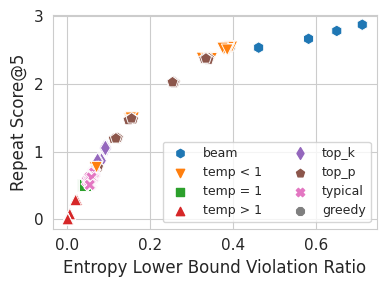

In [11]:
plt.rc('legend', fontsize=9)    # legend fontsize
fig, ax = plt.subplots(figsize=(4,3), tight_layout=True)

sns.set_style('white') # darkgrid, white grid, dark, white and ticks

sns.scatterplot(data=correlation_data, x='lower_bound_violation_ratio', y='repeat_score@5', ax=ax, hue='Decoding Method', style='Decoding Method', markers=markers, s=70)
# correlation_data.plot.scatter()
ax.set_xlabel("Entropy Lower Bound Violation Ratio")
ax.set_ylabel("Repeat Score@5")
sns.move_legend(ax, loc="lower right", ncol=2, title=None)


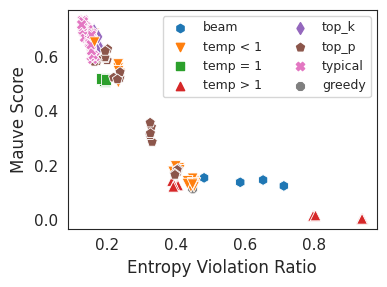

In [30]:
fig, ax = plt.subplots(figsize=(4,3), tight_layout=True)

sns.set_style('white') # darkgrid, white grid, dark, white and ticks

sns.scatterplot(data=correlation_data, x='entropy_violation_ratio', y='mauve', ax=ax, hue='Decoding Method', style='Decoding Method', markers=markers, s=60)
# correlation_data.plot.scatter()
ax.set_xlabel("Entropy Violation Ratio")
ax.set_ylabel("Mauve Score")
sns.move_legend(ax, loc="upper right", ncol=2, title=None)

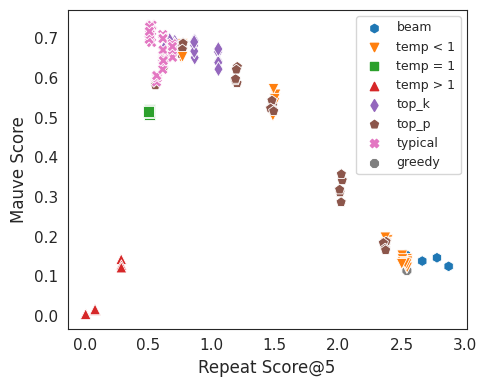

In [36]:
fig, ax = plt.subplots(figsize=(5,4), tight_layout=True)

sns.set_style('white') # darkgrid, white grid, dark, white and ticks

sns.scatterplot(data=correlation_data, x='repeat_score@5', y='mauve', ax=ax, hue='Decoding Method', style='Decoding Method', markers=markers, s=60)
# correlation_data.plot.scatter()
ax.set_xlabel("Repeat Score@5")
ax.set_ylabel("Mauve Score")
sns.move_legend(ax, loc="upper right", ncol=1,  title=None,)

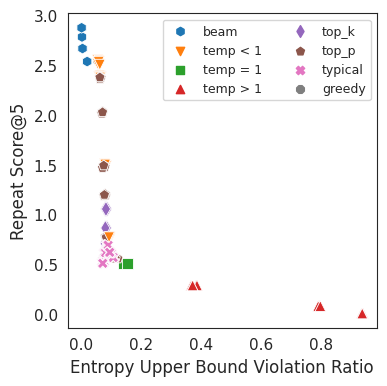

In [34]:
fig, ax = plt.subplots(figsize=(4,4), tight_layout=True)

sns.set_style('white') # darkgrid, white grid, dark, white and ticks

sns.scatterplot(data=correlation_data, y='repeat_score@5', x='upper_bound_violation_ratio', ax=ax, hue='Decoding Method', style='Decoding Method', markers=markers, s=60)
# correlation_data.plot.scatter()
ax.set_ylabel("Repeat Score@5")
ax.set_xlabel("Entropy Upper Bound Violation Ratio")
sns.move_legend(ax, loc="upper right", ncol=2, title=None)

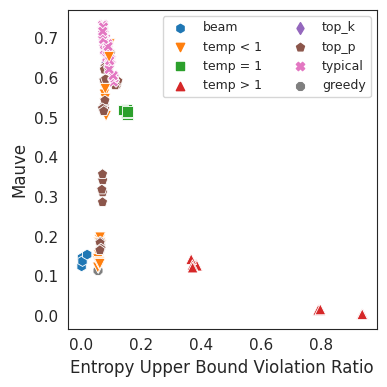

In [35]:
fig, ax = plt.subplots(figsize=(4,4), tight_layout=True)

sns.set_style('white') # darkgrid, white grid, dark, white and ticks

sns.scatterplot(data=correlation_data, y='mauve', x='upper_bound_violation_ratio', ax=ax, hue='Decoding Method', style='Decoding Method', markers=markers, s=60)
# correlation_data.plot.scatter()
ax.set_ylabel("Mauve")
ax.set_xlabel("Entropy Upper Bound Violation Ratio")
sns.move_legend(ax, loc="upper right", ncol=2, title=None)

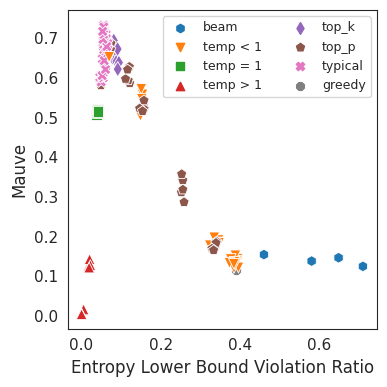

In [37]:
fig, ax = plt.subplots(figsize=(4,4), tight_layout=True)

sns.set_style('white') # darkgrid, white grid, dark, white and ticks

sns.scatterplot(data=correlation_data, y='mauve', x='lower_bound_violation_ratio', ax=ax, hue='Decoding Method', style='Decoding Method', markers=markers, s=60)
# correlation_data.plot.scatter()
ax.set_ylabel("Mauve")
ax.set_xlabel("Entropy Lower Bound Violation Ratio")
sns.move_legend(ax, loc="upper right", ncol=2, title=None)

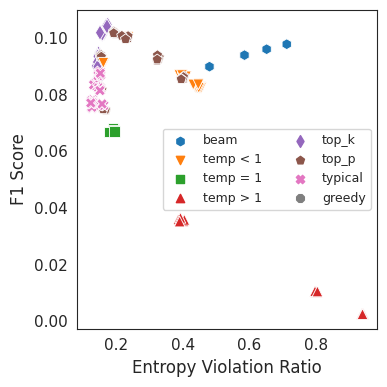

In [12]:
fig, ax = plt.subplots(figsize=(4,4), tight_layout=True)

sns.set_style('white') # darkgrid, white grid, dark, white and ticks

sns.scatterplot(data=correlation_data, x='entropy_violation_ratio', y='f1_score', ax=ax, hue='Decoding Method', style='Decoding Method', markers=markers, s=60)
# correlation_data.plot.scatter()
ax.set_xlabel("Entropy Violation Ratio")
ax.set_ylabel("F1 Score")
sns.move_legend(ax, loc="center right", ncol=2, title=None)

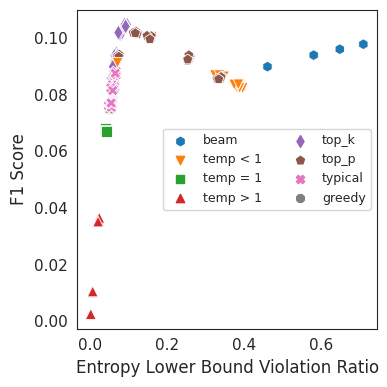

In [14]:
fig, ax = plt.subplots(figsize=(4,4), tight_layout=True)

sns.set_style('white') # darkgrid, white grid, dark, white and ticks

sns.scatterplot(data=correlation_data, x='lower_bound_violation_ratio', y='f1_score', ax=ax, hue='Decoding Method', style='Decoding Method', markers=markers, s=60)
# correlation_data.plot.scatter()
ax.set_xlabel("Entropy Lower Bound Violation Ratio")
ax.set_ylabel("F1 Score")
sns.move_legend(ax, loc="center right", ncol=2, title=None)

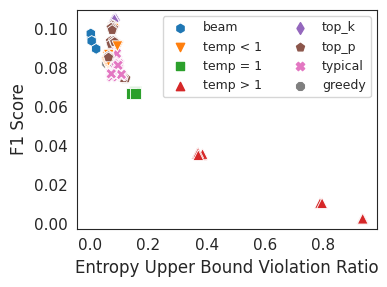

In [46]:
fig, ax = plt.subplots(figsize=(4,3), tight_layout=True)

sns.set_style('white') # darkgrid, white grid, dark, white and ticks

sns.scatterplot(data=correlation_data, x='upper_bound_violation_ratio', y='f1_score', ax=ax, hue='Decoding Method', style='Decoding Method', markers=markers, s=60)
# correlation_data.plot.scatter()
ax.set_xlabel("Entropy Upper Bound Violation Ratio")
ax.set_ylabel("F1 Score")
sns.move_legend(ax, loc="upper right", ncol=2, title=None)

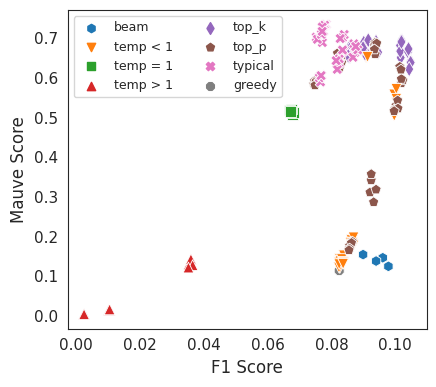

In [15]:
fig, ax = plt.subplots(figsize=(4.5,4), tight_layout=True)

sns.set_style('white') # darkgrid, white grid, dark, white and ticks

sns.scatterplot(data=correlation_data, x='f1_score', y='mauve', ax=ax, hue='Decoding Method', style='Decoding Method', markers=markers, s=60)
# correlation_data.plot.scatter()
ax.set_xlabel("F1 Score")
ax.set_ylabel("Mauve Score")
sns.move_legend(ax, loc="upper left", ncol=2, title=None)

# EAD Analysis

In [5]:
ead_data = pd.read_csv('/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/v4_sampling_analysis_7/compiled_results_plus.tsv', sep='\t', index_col=0)
ead_data

,repeat_score@5,ngram_repeat@3,f1_score,entropy_violation_ratio,num_generations,avg_compute_time_in_secs,upper_bound_violation_ratio,lower_bound_violation_ratio,mauve,std_dev,Type,Till,Decoding Method,dataset
0,0.663759,2.577831,0.084241,0.132086,7713,0,0.066083,0.066003,0.704040,0.5,EUI,0,tau=0.2,data/wiki_rankgen/generated/gpt2_xl/v4_samplin...
41,0.699534,2.971667,0.087901,0.139712,7713,0,0.070281,0.069431,0.690153,0.5,EUI,5,tau=0.2,data/wiki_rankgen/generated/gpt2_xl/v4_samplin...
31,0.695630,2.521057,0.089923,0.115665,7713,0,0.071324,0.044342,0.687763,0.5,ELI+EUI,10,tau=0.2,data/wiki_rankgen/generated/gpt2_xl/v4_samplin...
17,0.712840,2.841342,0.088245,0.124087,7713,0,0.069077,0.055011,0.686383,0.8,ELI+EUI,5,tau=0.2,data/wiki_rankgen/generated/gpt2_xl/v4_samplin...
2,0.769862,4.090810,0.085243,0.145042,7713,0,0.069725,0.075317,0.683917,1.0,EUI,0,tau=0.2,data/wiki_rankgen/generated/gpt2_xl/v4_samplin...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,2.178940,31.452675,0.088332,0.262457,7713,0,0.066761,0.195695,0.298429,1.5,ELI,5,ELI,data/wiki_rankgen/generated/gpt2_xl/v4_samplin...
62,2.152819,30.685060,0.088599,0.252582,7713,0,0.064159,0.188423,0.296394,1.2,ELI,10,ELI,data/wiki_rankgen/generated/gpt2_xl/v4_samplin...
65,2.119432,29.812801,0.089122,0.231874,7713,0,0.067159,0.164715,0.293264,0.5,ELI,10,ELI,data/wiki_rankgen/generated/gpt2_xl/v4_samplin...
61,2.180463,31.496877,0.088210,0.261624,7713,0,0.066482,0.195142,0.285339,1.5,ELI,10,ELI,data/wiki_rankgen/generated/gpt2_xl/v4_samplin...


### EUI vs ELI vs EUI+ELI

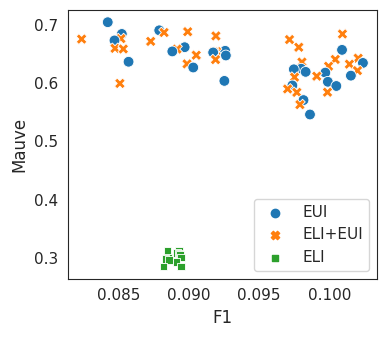

In [19]:
fig, ax = plt.subplots(figsize=(4,3.5), tight_layout=True)

sns.set_style('white') # darkgrid, white grid, dark, white and ticks

# type_markers = {'EUI': "8", "EUI": "h", "ELI+EUI": "s"}

sns.scatterplot(data=ead_data, x='f1_score', y='mauve', ax=ax, hue='Type', style='Type',  s=60)
# correlation_data.plot.scatter()
ax.set_xlabel("F1")
ax.set_ylabel("Mauve")
sns.move_legend(ax, loc="lower right", ncol=1,  title=None,)

### EUI vs EUI+ELI for k=30 

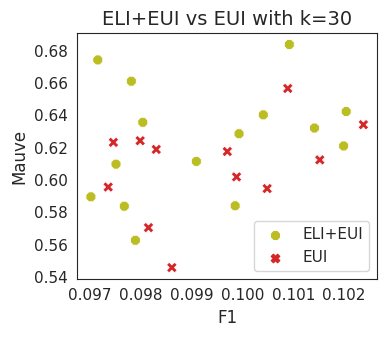

In [68]:
fig, ax = plt.subplots(figsize=(4,3.5), tight_layout=True)

sns.set_style('white') # darkgrid, white grid, dark, white and ticks
non_eli_data = ead_data[(ead_data['Type'] != 'ELI') & (ead_data['Decoding Method'] == 'k=30')]

type_markers = {'EUI': "X", "ELI": "h", "ELI+EUI": "8"}

sns.scatterplot(data=non_eli_data, x='f1_score', y='mauve', ax=ax, hue='Type', style='Type',  s=60, palette=['tab:olive', 'tab:red'], markers=type_markers).set(title="ELI+EUI vs EUI with k=30")
# correlation_data.plot.scatter()
ax.set_xlabel("F1")
ax.set_ylabel("Mauve")
sns.move_legend(ax, loc="lower right", ncol=1,  title=None,)

### EUI vs EUI+ELI for tau=0.2  

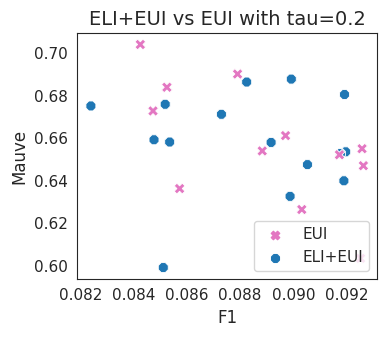

In [67]:
fig, ax = plt.subplots(figsize=(4,3.5), tight_layout=True)

sns.set_style('white') # darkgrid, white grid, dark, white and ticks
non_eli_data = ead_data[(ead_data['Type'] != 'ELI') & (ead_data['Decoding Method'] == 'tau=0.2')]

type_markers = {'EUI': "X", "ELI": "h", "ELI+EUI": "8"}

sns.scatterplot(data=non_eli_data, x='f1_score', y='mauve', ax=ax, hue='Type', style='Type', s=60, palette=['tab:pink', 'tab:blue'], markers=type_markers).set(title="ELI+EUI vs EUI with tau=0.2")
# correlation_data.plot.scatter()
ax.set_xlabel("F1")
ax.set_ylabel("Mauve")
sns.move_legend(ax, loc="lower right", ncol=1,  title=None,)

### Sampling Method

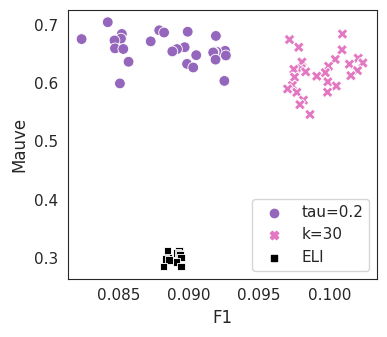

In [33]:
fig, ax = plt.subplots(figsize=(4,3.5), tight_layout=True)

sns.set_style('white') # darkgrid, white grid, dark, white and ticks

# type_markers = {'EUI': "8", "EUI": "h", "ELI+EUI": "s"}

sns.scatterplot(data=ead_data, x='f1_score', y='mauve', ax=ax, hue='Decoding Method', style='Decoding Method',  s=60, palette=['tab:purple', 'tab:pink', 'black']) #c=ead_data['Decoding Method'].map({'tau=0.2': 'tab:purple', 'k=30': 'tab:pink', 'ELI': 'black'}))
# correlation_data.plot.scatter()
ax.set_xlabel("F1")
ax.set_ylabel("Mauve")
sns.move_legend(ax, loc="lower right", ncol=1,  title=None,)

### STD Dev Split   

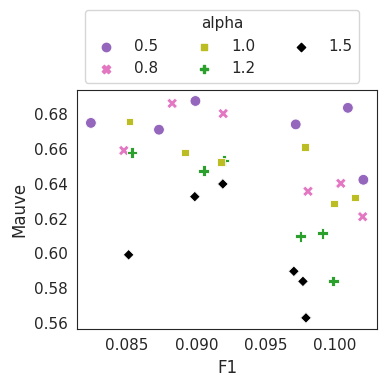

In [85]:
fig, ax = plt.subplots(figsize=(4,4), tight_layout=True)

sns.set_style('white') # darkgrid, white grid, dark, white and ticks

non_eli_data = ead_data[(ead_data['Type'] == 'ELI+EUI')]
sns.scatterplot(data=non_eli_data, x='f1_score', y='mauve', ax=ax, hue='std_dev', style='std_dev',  s=60, palette=['tab:purple', 'tab:pink', 'tab:olive', 'tab:green', 'black'])
# correlation_data.plot.scatter()
ax.set_xlabel("F1")
ax.set_ylabel("Mauve")
sns.move_legend(ax, loc="lower left", ncol=3,  title="alpha", bbox_to_anchor=(0, 1))

Mauve vs Repeat for EUI vs EUI+ELI  

/tmp/ipykernel_64942/3788332742.py:6: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.scatterplot(data=non_eli_data, y='mauve', x='repeat_score@5', ax=ax, hue='Type', style='Type',  s=60, palette=['tab:purple', 'tab:pink', 'tab:olive', 'tab:green', 'black'])


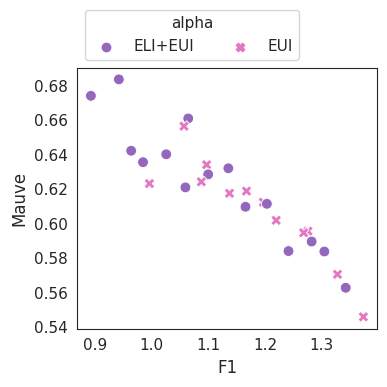

In [10]:
fig, ax = plt.subplots(figsize=(4,4), tight_layout=True)

sns.set_style('white') # darkgrid, white grid, dark, white and ticks

non_eli_data = ead_data[(ead_data['Type'] != 'ELI') & (ead_data['Decoding Method'] =='k=30')]
sns.scatterplot(data=non_eli_data, y='mauve', x='repeat_score@5', ax=ax, hue='Type', style='Type',  s=60, palette=['tab:purple', 'tab:pink', 'tab:olive', 'tab:green', 'black'])
# correlation_data.plot.scatter()
ax.set_xlabel("F1")
ax.set_ylabel("Mauve")
sns.move_legend(ax, loc="lower left", ncol=3,  title="alpha", bbox_to_anchor=(0, 1))